In [11]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

In [12]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [13]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((100,64*64))
trX=trX/255
trX[trX>=0.5]=1
trX[trX<=0.5]=0
data1=trX
%matplotlib inline
for i in range(100):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    temp[temp>=0.5]=1
    temp[temp<=0.5]=0
    data2[i,:]=temp.reshape(-1)

In [14]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

# def batchnorm( x, g=None, b=None, eps=1e-8 ):
#     if x.ndim == 4:
#         m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
#         v = tensor.mean(tensor.sqr(x - m), 
#                           axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

#         x = (x - m) / tensor.sqrt( v + eps )
#         if g is not None and b is not None:
#             x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

#     elif x.ndim == 2:
#         m = tensor.mean(x, axis=0)
#         v = tensor.mean(tensor.sqr(x - m), axis=0)

#         x = (x - m) / tensor.sqrt( v + eps )
#         if g is not None and b is not None:
#             x = x*g + b

#     return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [15]:
import sys
sys.path.append('..')

import os
import json
import scipy.io
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import math
import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import conv_cond_concat, deconv, dropout, batchnorm
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score
np.set_printoptions(threshold='nan')
#from load import mnist_with_valid_set

#trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#image = scipy.io.loadmat('WB_test64_GAN.mat')
#data1=np.abs(image['WB_test64_GAN']-1)

vaX= data2[0:100]
trX= data2[0:100]
#vaX= data2
#trX= data2
vaX = floatX(vaX)

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
#ny = 10           # # of classes
nbatch = 10      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 30          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 40          # # of gen filters in first conv layer
ndf = 40          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 10000       # # of iter at starting learning rate
niter_decay = 0 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
#ntrain, nval, ntest = len(trX), len(vaX), len(teX)
#ntrain = len(trX)

def transform(X):
    return (floatX(X)).reshape(-1, nc, npx, npx)
    #return (floatX(X)).reshape(-1, nc, npx, npx)
def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()

bce = T.nnet.binary_crossentropy
tanh = activations.Tanh()

eifn = inits.Normal(scale=0.02)
gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)

#generator
gw  = gifn((nz, ngf*8*4*4), 'gw')
gg = gain_ifn((ngf*8*4*4), 'gg')
gb = bias_ifn((ngf*8*4*4), 'gb')
gw2 = gifn((ngf*8, ngf*4, 5, 5), 'gw2')
gg2 = gain_ifn((ngf*4), 'gg2')
gb2 = bias_ifn((ngf*4), 'gb2')
gw3 = gifn((ngf*4, ngf*2, 5, 5), 'gw3')
gg3 = gain_ifn((ngf*2), 'gg3')
gb3 = bias_ifn((ngf*2), 'gb3')
gw4 = gifn((ngf*2, ngf, 5, 5), 'gw4')
gg4 = gain_ifn((ngf), 'gg4')
gb4 = bias_ifn((ngf), 'gb4')
gwx = gifn((ngf, nc, 5, 5), 'gwx')

#discriminator
dw  = difn((ndf, nc, 5, 5), 'dw')
dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')
dw3 = difn((ndf*4, ndf*2, 5, 5), 'dw3')
dg3 = gain_ifn((ndf*4), 'dg3')
db3 = bias_ifn((ndf*4), 'db3')
dw4 = difn((ndf*8, ndf*4, 5, 5), 'dw4')
dg4 = gain_ifn((ndf*8), 'dg4')
db4 = bias_ifn((ndf*8), 'db4')
dwy = difn((ndf*8*4*4, 1), 'dwy')

gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gw4, gg4, gb4, gwx]
discrim_params = [dw, dw2, dg2, db2, dw3, dg3, db3, dw4, dg4, db4, dwy]

def gen(Z, w, g, b, w2, g2, b2, w3, g3, b3, w4, g4, b4, wx):
    h = relu(batchnorm(T.dot(Z, w), g=g, b=b))
    h = h.reshape((h.shape[0], ngf*8, 4, 4))
    h2 = relu(batchnorm(deconv(h, w2, subsample=(2, 2), border_mode=(2, 2)), g=g2, b=b2))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)), g=g3, b=b3))
    h4 = relu(batchnorm(deconv(h3, w4, subsample=(2, 2), border_mode=(2, 2)), g=g4, b=b4))
    x = sigmoid(deconv(h4, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def discrim(X, w, w2, g2, b2, w3, g3, b3, w4, g4, b4, wy):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)), g=g2, b=b2))
    h3 = lrelu(batchnorm(dnn_conv(h2, w3, subsample=(2, 2), border_mode=(2, 2)), g=g3, b=b3))
    h4 = lrelu(batchnorm(dnn_conv(h3, w4, subsample=(2, 2), border_mode=(2, 2)), g=g4, b=b4))
    h4 = T.flatten(h4, 2)
    y = sigmoid(T.dot(h4, wy))
    return y

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
#updates = d_updates + g_updates

print 'COMPILING......'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)


#sample_zmb = floatX(np_rng.uniform(-1., 1., size=(nvis, nz)))

vaX = vaX.reshape(len(vaX), -1)    

n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
vae_cost_error=[]
gen_cost_error=[]
dis_cost_error=[]
t = time()
iter_error=0
print 'start training......'


COMPILING......
37.57 seconds to compile theano functions
start training......


In [16]:
for epoch in range(1,2*niter):
    for imb in iter_data(trX, size=nbatch):
        imb = transform(imb)
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    if (epoch) % 10 == 0:
        print '%.0f %.4f %.4f'%(epoch, g_cost, d_cost)
#     if n_epochs > niter:
#         lrt.set_value(floatX(lrt.get_value() - lr/niter_decay))

10 6.4124 0.0079
20 7.0673 0.0024
30 8.9782 0.2061
40 5.4393 0.0130
50 4.1370 0.0359
60 0.1320 3.1420
70 5.1126 0.0778
80 4.4473 0.0373
90 5.2391 0.0336
100 4.2169 0.0309
110 8.7151 0.2490
120 6.5517 0.0149
130 4.7800 0.0140
140 8.7085 0.0048
150 5.4414 0.0075
160 7.3839 0.0017
170 5.9250 0.0068
180 9.2795 0.0004
190 6.4130 0.0035
200 7.7081 0.0008
210 9.7225 0.0002
220 7.0868 0.0017
230 6.2196 0.0035
240 7.9747 0.0011
250 6.4272 0.0030
260 6.7562 0.0022
270 10.3711 0.0001
280 7.4699 0.0011
290 10.8627 0.0001
300 9.4502 0.0002
310 8.2734 0.0006
320 8.6203 0.0004
330 8.9507 0.0003
340 9.1377 0.0002
350 7.0268 0.0020
360 11.2040 0.0001
370 11.1797 0.0001
380 7.8564 0.0008
390 8.5787 0.0004
400 8.1569 0.0007
410 10.0304 0.0001
420 9.2142 0.0002
430 8.7868 0.0002
440 7.3804 0.0007
450 7.5871 0.0006
460 8.6948 0.0003
470 8.0336 0.0006
480 8.7650 0.0003
490 10.2280 0.0001
500 9.0575 0.0002
510 9.0353 0.0001
520 9.3170 0.0001
530 10.9101 0.0000
540 8.5944 0.0003
550 8.9206 0.0003
560 10.0578 

KeyboardInterrupt: 

In [240]:
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))
samples = np.asarray(_gen(sample_zmb))
grayscale_grid_vis(inverse_transform(samples), (10, 20), 'samplesXX/%s/%d.png'%(desc, n_epochs))

NameError: name 'desc' is not defined

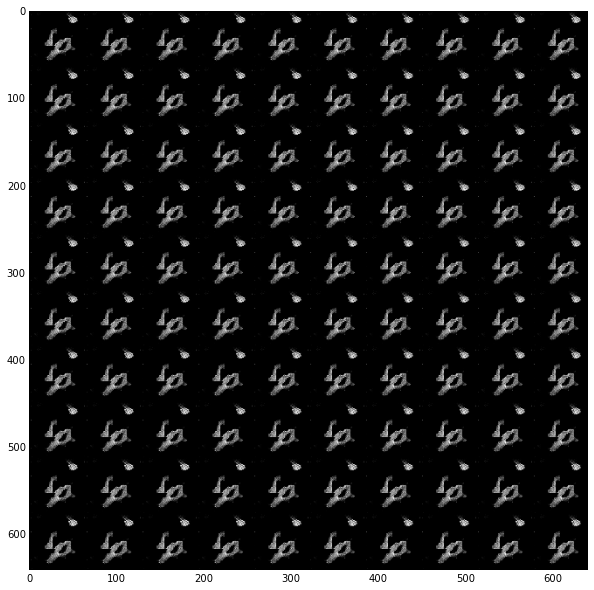

In [18]:
n = 10  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(10, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()